# Лабораторная: Поиск глобального экстремума одномерной функции
**Метод:** Strongin / Пиявский–Шуберт ·

**Функционал:**
- Ввод функции строкой, например: `x + sin(pi*x)`.
- Поиск глобального минимума липшицевой функции на отрезке `[a, b]` с точностью `eps` по оси *x*.
- Визуализация графика функции, ломаной по пробным точкам и найденного минимума.
- Отчёт: `x*`, `f(x*)`, число итераций, время работы.


## 0) Отрисовка графиков

In [6]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
print('Matplotlib backend OK')

Matplotlib backend OK


## 1) Реализация алгоритма

In [3]:

from __future__ import annotations
import math, time
from dataclasses import dataclass
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt

ALLOWED_NAMES: Dict[str, object] = {
    'pi': math.pi, 'e': math.e, 'tau': math.tau,
    'sin': math.sin, 'cos': math.cos, 'tan': math.tan,
    'asin': math.asin, 'acos': math.acos, 'atan': math.atan, 'atan2': math.atan2,
    'sinh': math.sinh, 'cosh': math.cosh, 'tanh': math.tanh,
    'exp': math.exp, 'log': math.log, 'log10': math.log10, 'sqrt': math.sqrt,
    'floor': math.floor, 'ceil': math.ceil, 'fabs': math.fabs, 'pow': pow,
    'abs': abs,
    'np': np,
}

def make_function(expr: str):
    expr = expr.strip()
    code = compile(expr, "<user-func>", "eval")
    for name in code.co_names:
        if name not in ALLOWED_NAMES and name != 'x':
            raise NameError(f"Недопустимое имя в выражении: {name}")
    def f(x: float) -> float:
        return float(eval(code, {**ALLOWED_NAMES, '__builtins__': {}}, {'x': x}))
    return f

@dataclass
class Result:
    x_min: float
    f_min: float
    iterations: int
    elapsed_sec: float
    xs: np.ndarray
    fs: np.ndarray

def strongin_minimize(f, a: float, b: float, eps: float = 0.05,
                      r: float = 1.3, max_iter: int = 1500) -> Result:
    if b <= a:
        raise ValueError("Должно быть b > a")
    start = time.perf_counter()
    xs = [a, b]
    fs = [f(a), f(b)]
    def sort_data():
        p = sorted(zip(xs, fs), key=lambda t: t[0])
        return [t[0] for t in p], [t[1] for t in p]
    it = 0
    while it < max_iter:
        it += 1
        xs, fs = sort_data()
        xs_arr = np.array(xs, dtype=float)
        fs_arr = np.array(fs, dtype=float)
        slopes = np.abs(np.diff(fs_arr) / np.diff(xs_arr))
        M = np.max(slopes) if slopes.size > 0 else 0.0
        m = r * M if M > 1e-12 else 1.0
        best_R = -np.inf
        best_idx = 1
        for i in range(1, len(xs_arr)):
            dx = xs_arr[i] - xs_arr[i-1]
            df = fs_arr[i] - fs_arr[i-1]
            R = m * dx + (df*df) / (m * dx) - 2.0 * (fs_arr[i] + fs_arr[i-1])
            if R > best_R:
                best_R = R
                best_idx = i
        xL, xR = xs_arr[best_idx-1], xs_arr[best_idx]
        fL, fR = fs_arr[best_idx-1], fs_arr[best_idx]
        x_new = 0.5 * (xL + xR) - (fR - fL) / (2.0 * m)
        x_new = min(max(x_new, xL + 1e-15), xR - 1e-15)
        f_new = f(x_new)
        xs.append(float(x_new))
        fs.append(float(f_new))
        max_len = np.max(np.diff(np.array(sort_data()[0])))
        if max_len <= eps:
            break
    xs, fs = sort_data()
    xs_arr = np.array(xs, dtype=float)
    fs_arr = np.array(fs, dtype=float)
    idx_best = int(np.argmin(fs_arr))
    elapsed = time.perf_counter() - start
    return Result(xs_arr[idx_best], fs_arr[idx_best], it, elapsed, xs_arr, fs_arr)

def visualize(f, a: float, b: float, result: Result,
              title: str = "Глобальный поиск минимума", n_curve: int = 400):
    xs_curve = np.linspace(a, b, n_curve)
    fs_curve = np.array([f(x) for x in xs_curve], dtype=float)
    plt.figure(figsize=(9, 5))
    plt.plot(xs_curve, fs_curve, label="f(x)")
    order = np.argsort(result.xs)
    plt.plot(result.xs[order], result.fs[order], marker='o', linestyle='--', label="Пробные точки (ломаная)")
    plt.scatter([result.x_min], [result.f_min], s=90, marker='*', label=f"Минимум ≈ ({result.x_min:.6g}, {result.f_min:.6g})")
    plt.title(title); plt.xlabel("x"); plt.ylabel("f(x)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def run_cli(func_expr: str, a: float, b: float,
            eps: float = 0.05, r: float = 1.3, max_iter: int = 1500,
            demo_plot: bool = True):
    f = make_function(func_expr)
    res = strongin_minimize(f, a, b, eps=eps, r=r, max_iter=max_iter)
    if demo_plot:
        visualize(f, a, b, res, title=f'Глобальный поиск: f(x) = {func_expr}', n_curve=400)
    print(f"Найденный минимум: x* ≈ {res.x_min:.10g}, f(x*) ≈ {res.f_min:.10g}")
    print(f"Итерации: {res.iterations}, время: {res.elapsed_sec:.4f} сек")
    return res


## 2) Быстрая демонстрация (мультиэкстремальная функция)

f(x) = x + sin(pi*x) на [-3.0, 3.0], eps=0.05, r=1.3, max_iter=1500


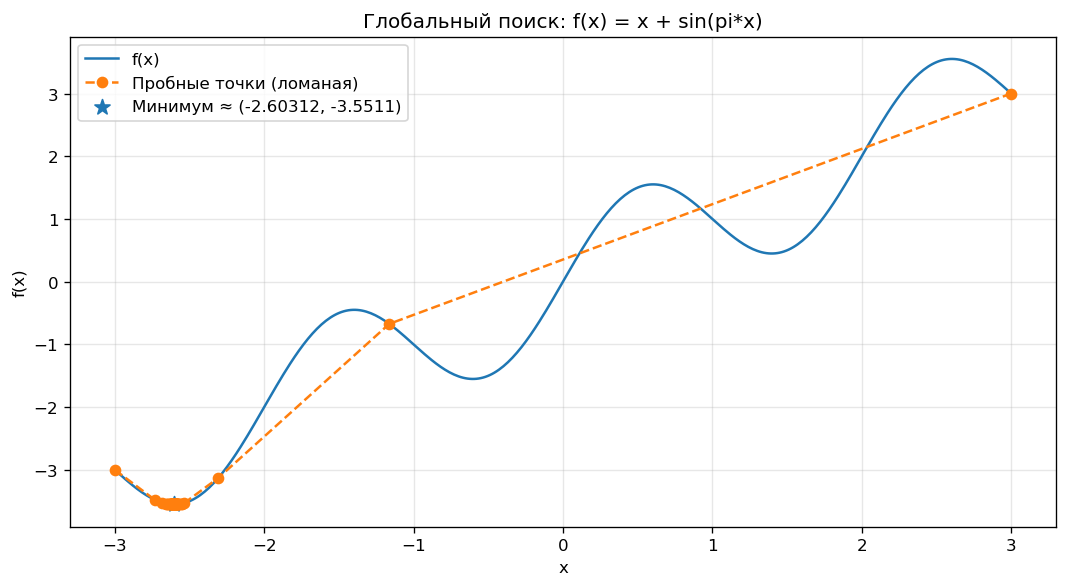

Найденный минимум: x* ≈ -2.603115474, f(x*) ≈ -3.551101966
Итерации: 1500, время: 2.0760 сек


In [4]:

expr = "x + sin(pi*x)"
a, b = -3.0, 3.0
eps = 0.05
r = 1.3
max_iter = 1500
print(f"f(x) = {expr} на [{a}, {b}], eps={eps}, r={r}, max_iter={max_iter}")
run_cli(expr, a, b, eps=eps, r=r, max_iter=max_iter, demo_plot=True);


## 3) Функция Растригина (много локальных минимумов)

f(x) = x**2 - 10*cos(2*pi*x) + 10 на [-5.12, 5.12], eps=0.05, r=1.3, max_iter=2000


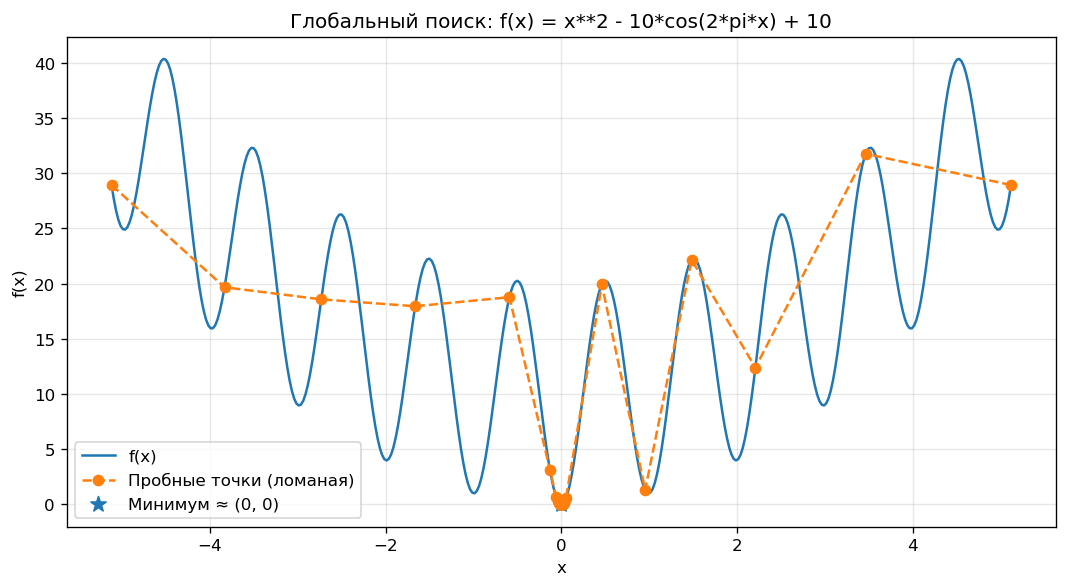

Найденный минимум: x* ≈ 0, f(x*) ≈ 0
Итерации: 2000, время: 3.6590 сек


In [5]:

expr = "x**2 - 10*cos(2*pi*x) + 10"
a, b = -5.12, 5.12
eps = 0.05
r = 1.3
max_iter = 2000
print(f"f(x) = {expr} на [{a}, {b}], eps={eps}, r={r}, max_iter={max_iter}")
run_cli(expr, a, b, eps=eps, r=r, max_iter=max_iter, demo_plot=True);
